# Optimization of a chirped dielectric structure using Nevergrad and PyMoosh

This file shows how to use the Chirped function implemented in the Photonics package of Nevergrad.

We first import all the modules needed. 

In [2]:
import numpy as np # to make arrays
import matplotlib.pyplot as plt # to trace figures
import nevergrad as ng # to run the optimization
from nevergrad.functions import photonics # to define the cost function
from PyMoosh import * # to analyse the result

## Optimisation using Nevergrad

### Define the cost function

The first stage of any optimization os to define the objective, usually on the form of a cost function. This cost function can be home-fabricated, for the example above we directly use the `Chirped` function of the module Photonics implemented in Nevergrad. This function is describes more precisely in https://github.com/facebookresearch/nevergrad/blob/main/nevergrad/functions/photonics/photonics.py and consist to optimize a multilayer with num_layers layers constituted of an alternance of two dielectric materials. The objective is to reflect 50 wavelengths between 500 and 800 nm. The substrate is the higher refractive index material and the superstrate is air. An impedance formalism is used to compute the reflection coefficient of the structure. 

In [3]:
num_layers = 30
func = photonics.Photonics(
    "chirped",
    num_layers
) 

### Define the parametrization

For each optimization we need to define some `parametrization` defining the type of variables to optimize. Those variables can be continuous or discrete, and of any dimension. Here, we let the variables take values between 10 and 300 nm (that is coherent to optimize thicknesses of the multilayer). As we using essentially evolutionary algorithms, some `child` is created. 

Here, we define the `reference child` by a suite of layers of 150 nm, the central part of our optimization domain. Otherwise, the child is by default a 0s vector and the optimization will not run because the child in not in the optimization domain.  

In [4]:
parametrization = ng.p.Array(shape=(num_layers,)) 
child = parametrization.spawn_child() 
print("value of the child before: ", child.value)
child.value = np.tile([150,150],int(num_layers/2))
print("value of the child after : ", child.value)
data = child.get_standardized_data(reference=parametrization)
print("data : ", data)
parametrization.value = data
parametrization = parametrization.set_bounds(lower=10, upper=300)

print("value of child : ", child.value)
print("data : ", data)
print("parametrization", parametrization)

value of child :  [150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150]
data :  [150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150.
 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150.
 150. 150.]
parametrization Array{(30,),Cl(10,300,b)}:[150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150.
 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150.
 150. 150.]


### Run the optimization

We can use many algorithms by using Nevergrad. Here, we use `DE`, and we give a `budget` of 1000 to run the optimization. This `budget` is the number of times the cost function will be calculated. The optimization finishes when all the budget is used. We need to ensure that the chosen budget is sufficient to let the algorithm converges to a solution. 

It is in the loop that the optimization performs. The `ask()` function generates some new structure, and we compute the `loss` (the value of the cost function) of this structure using the `func(x.value)` function. The optimization has in memory all the structures tested, so by using `recommendation()` method we ask wich structure is the best for now. The `loss2` array save the values of the best cost functions obtained after each iteration of the algorithm. 

`best` is a vector with the thicknesses of the structure.

`cf_best` is a vector with the associate cost function value. 

In [17]:
optim = ng.optimizers.registry["DE"](parametrization, budget =1000)

loss = np.zeros(optim.budget)
loss2 = np.zeros(optim.budget)

for i in range(optim.budget):
    x = optim.ask()
    loss[i] = func(x.value)
    optim.tell(x, loss[i])
    reco2 = optim.provide_recommendation()
    loss2[i] = func(reco2.value)
best = reco2.value
cf_best = func(best) 

### Verification of the convergence of the optimization

Here we check if the optimization has converged. We represent of a graph the cost function of the best structures in function of the iteration of the algorithms. We can so check if the budget is sufficient or if we need to increase it.  

best =  [115.9533333  227.33269446 117.59243138  88.70722085  96.34399021
  95.2460773   38.77126101 139.56848712  86.81384061  80.5170172
 170.48607488  94.49407495 242.65609482 104.90369801 156.1588163
 200.57926884 198.75987456  45.23515415 107.47263542  92.37307519
 144.61300966 192.23273377 249.62510209 150.43345735 122.98707375
  87.33828312 130.58643965 115.8616412  124.59753596  95.75726036]
best cost function =  0.5075015629474766


Text(0.5, 1.0, 'Convergence curve of the optimization')

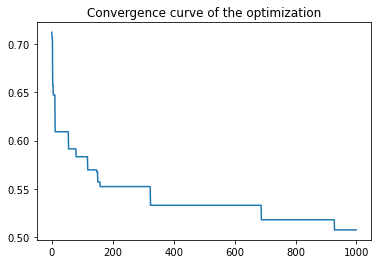

In [18]:
print("best = ", best)
print("best cost function = ", cf_best)

plt.figure(1)
plt.plot(loss2)
plt.title("Convergence curve of the optimization")

## Analyse of the result using Moosh

### Definition of the structure

In [19]:
materials = [1., 1.4142135623730951**2, 1.7320508075688772**2]
list = [2,1]
layer_type = [0] + (int(num_layers/2))*list + [2]
thickness = [0] + best.tolist() + [0]

multilayers = Structure(materials,layer_type,thickness)

### Visualization of the spectrum

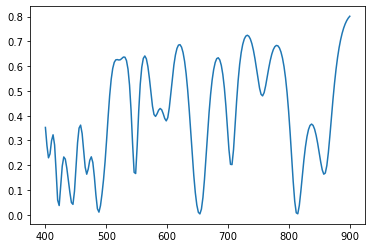

In [20]:
incidence = 0
polarization = 0 
wl_min = 400
wl_max = 900
n_points = 200

[wl,r,t,R,T] = Spectrum(multilayers, incidence,polarization,wl_min,wl_max,n_points)

plt.figure(2)
plt.plot(wl,R)

### Visualization of the structure

<Figure size 432x288 with 0 Axes>

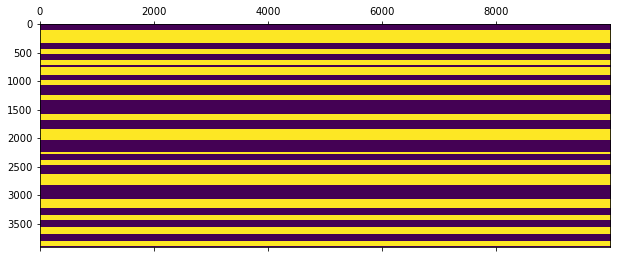

In [21]:
M = Visu_struct(multilayers,600)

plt.figure(3)
plt.matshow(M)
plt.show()

## Visualization of the field

It is first necessary to define a calculation window, as well as an incident beam.

-For the window, the class `Window` asks to provide the horizontal size of the window, the position of the incident beam with respect to the window (0 = all on the left, 1 = all on the right), the size one pixel horizontal and one pixel vertical size.

-For the beam, the class `Beam` asks to provide the wavelength, the angle of incidence, the polarization (0=TE,1=TM) and the horizontal waist.

Here, we ask the field map when we excite the optimized structure with a 600 nm wavelength with an incidence angle of 45 degrees in polarization TE (s polarization) and with a waist beam of 10 times the wavelength. 



Pixels horizontally: 1400
Incidence in degrees: 45.0
E//, TE, s polarization
Pixels vertically: 116


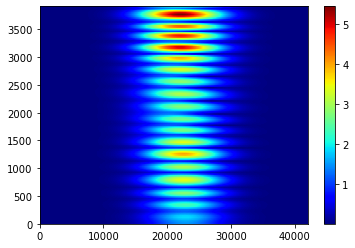

In [27]:
wavelength = 600
window = Window(70*wavelength, 0.5, 30., 30.)
beam = Beam(wavelength, np.pi/4,0,10*wavelength)

E = field(multilayers, beam, window)

plt.figure(4)
plt.imshow(abs(E),cmap='jet',extent=[0,window.width,0,sum(multilayers.thickness)],aspect='auto')
plt.colorbar()